In [1]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Linux-5.4.109+-x86_64-with-Ubuntu-18.04-bionic


In [2]:
from zipfile import ZipFile
zf = ZipFile('/content/drive/MyDrive/content/VideoViolence.zip', 'r')
zf.extractall('videoData')
zf.close()

In [3]:
import os
import cv2
import numpy as np
np.random.seed(1337) # just for reproducibility
import tensorflow
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model, Sequential
import tensorflow.keras.layers
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.model_selection import train_test_split
import tensorflow.keras.metrics as km
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [4]:
data_dir = "/content/videoData/Real Life Violence Dataset"
img_height , img_width = 90, 90
seq_len = 40
 
classes = ["NonViolence", "Violence"]

In [5]:
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list

In [6]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list[:600]:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
 
X, Y = create_data(data_dir)

Violence
NonViolence
Defected frame


In [7]:
print(np.shape(X))
print(np.shape(Y))

(1199, 40, 90, 90, 3)
(1199, 2)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1)

In [9]:
model = Sequential()
model.add(ConvLSTM2D(filters = 72, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(254, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation = "softmax"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 88, 88, 72)        194688    
_________________________________________________________________
dropout (Dropout)            (None, 88, 88, 72)        0         
_________________________________________________________________
flatten (Flatten)            (None, 557568)            0         
_________________________________________________________________
dense (Dense)                (None, 254)               141622526 
_________________________________________________________________
dropout_1 (Dropout)          (None, 254)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 510       
Total params: 141,817,724
Trainable params: 141,817,724
Non-trainable params: 0
__________________________________________

In [11]:


opt = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])



In [12]:

history = model.fit(x=X_train, y=y_train, epochs=10, batch_size = 2,validation_split=0.2)


Epoch 1/10
384/384 [==============================] - 566s 1s/step - loss: 2.4386 - accuracy: 0.5481 - val_loss: 0.5682 - val_accuracy: 0.6771
Epoch 2/10
384/384 [==============================] - 533s 1s/step - loss: 0.4728 - accuracy: 0.8195 - val_loss: 0.5077 - val_accuracy: 0.7083
Epoch 3/10
384/384 [==============================] - 532s 1s/step - loss: 0.3470 - accuracy: 0.8819 - val_loss: 0.6602 - val_accuracy: 0.6510
Epoch 4/10
384/384 [==============================] - 532s 1s/step - loss: 0.2070 - accuracy: 0.9418 - val_loss: 1.4369 - val_accuracy: 0.5938
Epoch 5/10
384/384 [==============================] - 530s 1s/step - loss: 0.1505 - accuracy: 0.9659 - val_loss: 0.4629 - val_accuracy: 0.7865
Epoch 6/10
384/384 [==============================] - 533s 1s/step - loss: 0.1881 - accuracy: 0.9298 - val_loss: 0.5555 - val_accuracy: 0.7344
Epoch 7/10
384/384 [==============================] - 532s 1s/step - loss: 0.0488 - accuracy: 0.9919 - val_loss: 0.5489 - val_accuracy: 0.7969

In [13]:


model.save('./cctvkaggle.h5')



In [ ]:
from IPython.display import FileLink
FileLink(r'./cctvkaggle.h5')

/content/cctvkaggle.h5

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score( y_pred,y_test))

0.5791666666666667


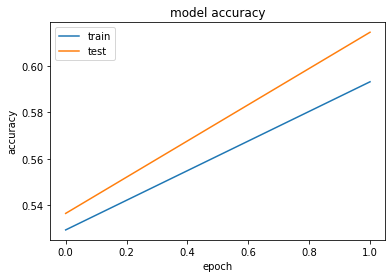

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model
import cv2
import numpy as np

model = load_model('./cctvkaggle.h5')

video_path = '/content/fight2.mp4'
category =['NonViolence', 'Violence']
frames = []
frame_count = 0
queue=[]
try:
    capture = cv2.VideoCapture(video_path)
    while (capture.isOpened()):
        ret, frame = capture.read()
          # Bail out when the video file ends
        frame = cv2.resize(frame, (90, 90))
        if not ret:
            break

    # Save each frame of the video to a list
        frame_count += 1
        frames.append(frame)

        if frame_count < 5:
            continue # capture frames until you get the required number for sequence
        else:
            frame_count = 0
    # For each frame, extract feature and prepare it for classification
        sequence = []
        for image in frames:
            sequence.append(image) 

        prediction = model.predict(np.expand_dims(sequence, axis=0))
        print(prediction)
        queue.append(prediction)
        results = np.array(queue).mean(axis=0)
        i = category[np.argmax(results)]
except Exception as e:
    print(str(e))
print('Predicted: '+ i)
capture.release()

[[0.41666853 0.5833315 ]]
[[0.41976818 0.5802318 ]]
[[0.41522223 0.5847778 ]]
[[0.40017974 0.5998203 ]]
[[0.40443572 0.59556425]]
[[0.4123162 0.5876838]]
[[0.42025653 0.57974344]]
[[0.40424776 0.59575224]]
[[0.4190498 0.5809502]]
[[0.41132095 0.588679  ]]
[[0.41117638 0.5888236 ]]
[[0.4196508 0.5803492]]
[[0.41292518 0.5870748 ]]
[[0.4023014 0.5976986]]
[[0.4038523  0.59614766]]
[[0.39715523 0.6028448 ]]
[[0.40083396 0.59916604]]
[[0.40124217 0.5987578 ]]
[[0.39947847 0.60052156]]
[[0.39723557 0.6027645 ]]
[[0.40724495 0.5927551 ]]
[[0.39723358 0.6027664 ]]
[[0.40671626 0.5932838 ]]
[[0.40497494 0.59502506]]
[[0.38865328 0.6113468 ]]
[[0.39746633 0.6025337 ]]
[[0.3979475 0.6020525]]
[[0.39749315 0.6025069 ]]
[[0.39768827 0.6023117 ]]
[[0.40170363 0.59829634]]
[[0.3938469  0.60615313]]
[[0.40389723 0.5961027 ]]
[[0.404374 0.595626]]
[[0.39743614 0.60256386]]
[[0.39367408 0.6063259 ]]
[[0.4003625  0.59963757]]
[[0.40152183 0.59847814]]
[[0.4086995  0.59130055]]
[[0.39928702 0.60071295]]


In [ ]:
from keras.models import load_model
import cv2
import numpy as np


model = load_model('./cctvkaggle.h5')

video_path = '/content/fight2.mp4'
category =['NonViolence', 'Violence']
frames = []
frame_count = 0
queue=[]
try:
    capture = cv2.VideoCapture(video_path)
    while (capture.isOpened()):
        ret, frame = capture.read()
          # Bail out when the video file ends
        frame = cv2.resize(frame, (90, 90))
        if not ret:
            break

    # Save each frame of the video to a list
        frame_count += 1
        frames.append(frame)

        if frame_count < 5:
            continue # capture frames until you get the required number for sequence
        else:
            frame_count = 0
    # For each frame, extract feature and prepare it for classification
        sequence = []
        for image in frames:
            sequence.append(image) 

        prediction = model.predict(np.expand_dims(sequence, axis=0))
        print(prediction)
        queue.append(prediction)
        results = np.array(queue).mean(axis=0)
        i = category[np.argmax(results)]
except Exception as e:
    print(str(e))
print('Predicted: '+ i)
capture.release()

SyntaxError: ignored